In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import stats
# set font size
mpl.rcParams.update({'font.size': 8})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [2]:
nerd_sqlite = '../../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [3]:
rg_ids = [123, 124, 129, 130]  # P4P6 rg_ids

query = """
SELECT *
FROM probe_tc_fits_view
WHERE fit_kind = 'round3_constrained'
  AND rg_id IN ({})
  AND rt_protocol = 'MRT'
ORDER BY rg_id
""".format(",".join(["?"] * len(rg_ids)))

df = read_sql(query, params=rg_ids)
conn.close()

In [4]:
# get max log_kobs for each nt_base and save in dict
max_logkobs = {}
for base in df['nt_base'].unique():
    df_base = df[df['nt_base'] == base]
    max_logkobs[base] = df_base['log_kobs'].max()
max_logkobs

def calc_dG(logkobs, logkadd):
    R = 1.9872036e-3  # kcal/(mol*K)
    T = 298.15  # K
    
    logKKp1 = logkobs - logkadd
    KKp1 = np.exp(logKKp1) # K / (K+1)
    K = KKp1 / (1 - KKp1)
    dG = -R * T * np.log(K)

    return dG


# calculate dG using base-specific max log_kobs
df['dG'] = df.apply(lambda row: calc_dG(row['log_kobs'], max_logkobs[row['nt_base']]), axis=1)
df

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_2857/4165455530.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  K = KKp1 / (1 - KKp1)


,fit_run_id,rg_id,nt_id,fit_kind,rg_label,temperature,probe,probe_conc,rt_protocol,buffer_id,...,nt_site,nt_base,kobs,log_kobs,log_kdeg,log_kobs_err,log_kdeg_err,r2,metadata_json,dG
0,274536,123,797,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,103,G,0.000660,-7.323764,-8.067974,0.296183,0.0,0.487337,"{""base"": ""G"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",1.337060
1,274537,123,798,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,104,A,0.022931,-3.775280,-8.067974,0.039808,0.0,0.981779,"{""base"": ""A"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.411026
2,274538,123,799,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,105,A,0.017473,-4.047125,-8.067974,0.045539,0.0,0.976153,"{""base"": ""A"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.638676
3,274539,123,800,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,106,U,0.000927,-6.983541,-8.067974,0.267403,0.0,0.538394,"{""base"": ""U"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.743259
4,274540,123,801,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,107,U,0.001103,-6.809645,-8.067974,0.144518,0.0,0.799772,"{""base"": ""U"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.607229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,275511,124,939,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,245,G,0.000381,-7.873467,-8.242844,0.577642,0.0,0.374830,"{""base"": ""G"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.688418
412,275516,124,944,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,250,G,0.000255,-8.273244,-8.242844,1.030822,0.0,0.158407,"{""base"": ""G"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.936470
413,275517,124,945,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,251,G,0.000253,-8.280811,-8.242844,1.323388,0.0,0.102497,"{""base"": ""G"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.941123
414,275520,124,948,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,254,G,0.000547,-7.510987,-8.242844,0.923467,0.0,0.190010,"{""base"": ""G"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.458484


In [25]:
select_df = df_mg[['nt_site', 'nt_base', 'dG','r2']]

# filter nt_base == C
select_df = select_df[select_df['nt_base'] == 'C']

# filter sites r2 < 0.5
select_df[select_df['r2'] < 0.5]

,nt_site,nt_base,dG,r2
232,127,C,3.239550,5.365484e-02
242,137,C,2.797763,3.411219e-01
248,143,C,3.389349,1.657800e-01
250,145,C,3.347443,1.034465e-01
294,189,C,18.109629,-2.124301e-12
298,193,C,3.078009,2.375263e-01
308,203,C,3.849673,3.222012e-02
309,204,C,20.314825,-1.876277e-13
314,209,C,3.651383,3.952032e-02
316,211,C,2.875074,2.601924e-01


In [5]:
## Analysis of correlation

def keep_higher_r2(df):
    """
     keep_higher_r2 between duplicate RT runs of the same reactions
    """
    for site in df['nt_site'].unique():
        # drop row with lower r2
        df_site = df[df['nt_site'] == site]
        if len(df_site) != 2:
            continue
        if df_site.iloc[0]['r2'] > df_site.iloc[1]['r2']:
            df = df.drop(df_site.index[1])
        else:
            df = df.drop(df_site.index[0])
    return df

df_nomg = df[df['buffer_id'] == 2]
df_nomg = keep_higher_r2(df_nomg)
df_mg = df[df['buffer_id'] == 3]
df_mg = keep_higher_r2(df_mg)
df_mg

# merge df_nomg and df_mg on nt_site and keep the following: nt_site, nt_base, log_kobs, log_kobs_err, dG, r2
# add suffix to all but nt_site and nt_base
df_merged = pd.merge(df_nomg[['nt_site', 'nt_base', 'log_kobs', 'log_kobs_err', 'dG', 'r2']],
                     df_mg[['nt_site', 'log_kobs', 'log_kobs_err', 'dG', 'r2']],
                     on=['nt_site'],
                     suffixes=('_nomg', '_mg'))

# filter to A and C only
df_merged_AC = df_merged[df_merged['nt_base'].isin(['A', 'C'])]

# filter to R2 > 0.5
df_merged_AC = df_merged_AC[(df_merged_AC['r2_nomg'] > 0.5) & (df_merged_AC['r2_mg'] > 0.5)]

canonical_annots = pd.read_csv('p4p6_canonical_annots.csv')
# merge on nt_site and nt_base
df_merged_AC = pd.merge(df_merged_AC, canonical_annots, on=['nt_site', 'nt_base'], how='left')
df_merged_AC

,nt_site,nt_base,log_kobs_nomg,log_kobs_err_nomg,dG_nomg,r2_nomg,log_kobs_mg,log_kobs_err_mg,dG_mg,r2_mg,canonical,lp_section,Unnamed: 4
0,104,A,-3.775280,0.039808,0.411026,0.981779,-3.795475,0.071300,0.428881,0.975766,3.0,not,1: canonical
1,105,A,-4.047125,0.045539,0.638676,0.976153,-4.165104,0.077981,0.730599,0.971924,3.0,not,2: base-triple
2,109,C,-4.365995,0.035195,0.707925,0.985545,-4.499681,0.083820,0.809164,0.966432,6.0,MCR,3: WW_non-canonical
3,113,A,-4.182189,0.028209,0.743639,0.990689,-4.636739,0.095737,1.071636,0.956610,4.0,not,4: NC
4,114,A,-3.406555,0.027499,0.043210,0.991309,-3.458740,0.033007,0.101494,0.994756,4.0,not,5: SS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,261,A,-5.490267,0.085721,1.630607,0.919276,-5.448170,0.086865,1.604038,0.963795,NaN,NaN,NaN
66,262,A,-4.551276,0.056110,1.012275,0.963976,-4.814791,0.059075,1.192756,0.982990,NaN,NaN,NaN
67,263,C,-6.721343,0.215547,2.246925,0.642335,-6.297629,0.260076,1.988792,0.747605,NaN,NaN,NaN
68,265,A,-6.427110,0.171735,2.208222,0.738889,-6.461498,0.181311,2.229078,0.859019,NaN,NaN,NaN


In [6]:
import numpy as np

def dG_to_percent_open(dG, T=296.15):
    """
    Convert ΔG (kcal/mol) to percent open using:
        K = exp(-ΔG / (RT))
        p_open = K / (1 + K)
    Default temperature = 296.15 K (23 °C).
    """
    R = 0.001987  # kcal/mol/K
    RT = R * T
    K = np.exp(-dG / RT)
    p_open = K / (1 + K)
    return 100 * p_open

df_explore = df_merged_AC[['nt_site', 'nt_base', 'dG_nomg', 'dG_mg']].copy()
df_explore['percent_open_nomg'] = dG_to_percent_open(df_explore['dG_nomg'])
df_explore['percent_open_mg'] = dG_to_percent_open(df_explore['dG_mg'])
df_explore

,nt_site,nt_base,dG_nomg,dG_mg,percent_open_nomg,percent_open_mg
0,104,A,0.411026,0.428881,33.214746,32.545128
1,105,A,0.638676,0.730599,25.249429,22.416360
2,109,C,0.707925,0.809164,23.093605,20.180098
3,113,A,0.743639,1.071636,22.033321,13.929996
4,114,A,0.043210,0.101494,48.165087,45.698723
...,...,...,...,...,...,...
65,261,A,1.630607,1.604038,5.891043,6.146400
66,262,A,1.012275,1.192756,15.184041,11.640270
67,263,C,2.246925,1.988792,2.149135,3.293557
68,265,A,2.208222,2.229078,2.291889,2.213850


In [7]:
ddG_merged = df_merged_AC.copy()
ddG_merged['ddG'] = df_merged_AC['dG_mg'] - df_merged_AC['dG_nomg']

# melt dG_nomg and dG_mg into dG and new column "buffer" 
df_merged_AC = pd.melt(df_merged_AC,
                       id_vars=['nt_site', 'nt_base', 'canonical', 'lp_section'],
                       value_vars=['dG_nomg', 'dG_mg'],
                       var_name='buffer',
                       value_name='dG')

In [30]:
df_merged_AC[df_merged_AC['canonical'] == 2]

,nt_site,nt_base,canonical,lp_section,buffer,dG
14,136,A,2.0,not,dG_nomg,1.190258
38,197,C,2.0,J5/5a,dG_nomg,0.407544
84,136,A,2.0,not,dG_mg,1.310905
108,197,C,2.0,J5/5a,dG_mg,1.923874


In [29]:
df_merged_AC

,nt_site,nt_base,canonical,lp_section,buffer,dG
0,104,A,3.0,not,dG_nomg,0.411026
1,105,A,3.0,not,dG_nomg,0.638676
2,109,C,6.0,MCR,dG_nomg,0.707925
3,113,A,4.0,not,dG_nomg,0.743639
4,114,A,4.0,not,dG_nomg,0.043210
...,...,...,...,...,...,...
135,261,A,NaN,NaN,dG_mg,1.604038
136,262,A,NaN,NaN,dG_mg,1.192756
137,263,C,NaN,NaN,dG_mg,1.988792
138,265,A,NaN,NaN,dG_mg,2.229078


In [31]:
ddG_merged

,nt_site,nt_base,log_kobs_nomg,log_kobs_err_nomg,dG_nomg,r2_nomg,log_kobs_mg,log_kobs_err_mg,dG_mg,r2_mg,canonical,lp_section,Unnamed: 4,ddG
0,104,A,-3.775280,0.039808,0.411026,0.981779,-3.795475,0.071300,0.428881,0.975766,ncWW,not,1: canonical,0.017855
1,105,A,-4.047125,0.045539,0.638676,0.976153,-4.165104,0.077981,0.730599,0.971924,ncWW,not,2: base-triple,0.091923
2,109,C,-4.365995,0.035195,0.707925,0.985545,-4.499681,0.083820,0.809164,0.966432,LP,MCR,3: WW_non-canonical,0.101239
3,113,A,-4.182189,0.028209,0.743639,0.990689,-4.636739,0.095737,1.071636,0.956610,NC,not,4: NC,0.327997
4,114,A,-3.406555,0.027499,0.043210,0.991309,-3.458740,0.033007,0.101494,0.994756,NC,not,5: SS,0.058285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,261,A,-5.490267,0.085721,1.630607,0.919276,-5.448170,0.086865,1.604038,0.963795,NaN,NaN,NaN,-0.026569
66,262,A,-4.551276,0.056110,1.012275,0.963976,-4.814791,0.059075,1.192756,0.982990,NaN,NaN,NaN,0.180482
67,263,C,-6.721343,0.215547,2.246925,0.642335,-6.297629,0.260076,1.988792,0.747605,NaN,NaN,NaN,-0.258134
68,265,A,-6.427110,0.171735,2.208222,0.738889,-6.461498,0.181311,2.229078,0.859019,NaN,NaN,NaN,0.020856


In [9]:
# ddG filter to canonical == 1
ddG_merged[ddG_merged['canonical'] == 1]['ddG']

# wilcoxon signed-rank test on ddG_merged[ddG_merged['canonical'] == 1]['ddG']
stats.wilcoxon(ddG_merged[ddG_merged['canonical'] == 1]['ddG'])

WilcoxonResult(statistic=22.0, pvalue=0.0005102157592773438)

In [10]:
ddG_merged[ddG_merged['canonical'] == 1]['ddG'].sum()

4.491773692007255

In [11]:
# ddG_merged filter to sites in 223, 225, 226, 248
ddG_merged[ddG_merged['nt_site'].isin([183, 184, 186, 187, 136, 137, 138, 210, 208, 109])]#['ddG'].sum()

,nt_site,nt_base,log_kobs_nomg,log_kobs_err_nomg,dG_nomg,r2_nomg,log_kobs_mg,log_kobs_err_mg,dG_mg,r2_mg,canonical,lp_section,Unnamed: 4,ddG
2,109,C,-4.365995,0.035195,0.707925,0.985545,-4.499681,0.083820,0.809164,0.966432,6.0,MCR,3: WW_non-canonical,0.101239
14,136,A,-4.811072,0.047451,1.190258,0.973907,-4.992670,0.076422,1.310905,0.971821,2.0,not,NaN,0.120647
15,138,C,-6.420077,0.036853,2.063715,0.983988,-7.104634,0.123733,2.478256,0.928946,1.0,not,NaN,0.414541
32,183,A,-3.754113,0.032376,0.392116,0.987873,-3.935793,0.066832,0.548481,0.978589,6.0,MC,NaN,0.156365
33,184,A,-4.223345,0.045475,0.774794,0.976146,-5.535473,0.096469,1.659059,0.955715,6.0,MC,NaN,0.884265
34,186,A,-3.982814,0.023949,0.587027,0.993296,-6.852766,0.116268,2.465339,0.936750,6.0,MC,NaN,1.878312
35,187,A,-3.915590,0.031075,0.531701,0.988777,-5.011393,0.074330,1.323198,0.973295,6.0,MC,NaN,0.791498
42,208,C,-5.340206,0.091102,1.387431,0.909818,-6.166486,0.252128,1.908191,0.759160,1.0,not,NaN,0.520760
43,210,A,-4.421445,0.016317,0.920283,0.996855,-4.396738,0.090460,0.902501,0.961160,5.0,not,NaN,-0.017782


In [12]:
ddG_merged[ddG_merged['canonical'] == 0]['ddG'].sum()

0.0

In [13]:
ddG_merged[ddG_merged['canonical'] == 1]['ddG'].sum()

4.491773692007255

In [14]:
ddG_merged[ddG_merged['canonical'] == 1]

,nt_site,nt_base,log_kobs_nomg,log_kobs_err_nomg,dG_nomg,r2_nomg,log_kobs_mg,log_kobs_err_mg,dG_mg,r2_mg,canonical,lp_section,Unnamed: 4,ddG
6,121,C,-5.052206,0.053141,1.197467,0.967432,-5.431401,0.136899,1.446407,0.914677,1.0,J5/5a,NaN,0.248940
11,128,C,-6.648599,0.062301,2.202817,0.955552,-7.638700,0.332395,2.798410,0.644252,1.0,not,NaN,0.595594
12,132,C,-5.485336,0.080877,1.481065,0.927520,-6.238667,0.205574,1.952603,0.825821,1.0,not,NaN,0.471537
13,133,A,-5.047218,0.038526,1.346655,0.982710,-5.485158,0.086610,1.627387,0.964002,1.0,not,NaN,0.280732
15,138,C,-6.420077,0.036853,2.063715,0.983988,-7.104634,0.123733,2.478256,0.928946,1.0,not,NaN,0.414541
18,146,A,-5.563755,0.072625,1.676820,0.940697,-5.217831,0.059825,1.457237,0.982518,1.0,not,NaN,-0.219582
22,154,C,-7.491472,0.251410,2.710345,0.568786,-7.195520,0.263788,2.532889,0.742018,1.0,not,NaN,-0.177455
23,159,A,-5.686014,0.087511,1.753266,0.916111,-6.071853,0.135717,1.991625,0.915840,1.0,not,NaN,0.238359
24,161,A,-5.798670,0.061835,1.823277,0.956265,-6.110681,0.193970,2.015412,0.841944,1.0,not,NaN,0.192135
36,192,A,-5.417007,0.044968,1.584322,0.976416,-5.727244,0.230605,1.778933,0.790495,1.0,not,NaN,0.194612


In [15]:
ddG_merged

,nt_site,nt_base,log_kobs_nomg,log_kobs_err_nomg,dG_nomg,r2_nomg,log_kobs_mg,log_kobs_err_mg,dG_mg,r2_mg,canonical,lp_section,Unnamed: 4,ddG
0,104,A,-3.775280,0.039808,0.411026,0.981779,-3.795475,0.071300,0.428881,0.975766,3.0,not,1: canonical,0.017855
1,105,A,-4.047125,0.045539,0.638676,0.976153,-4.165104,0.077981,0.730599,0.971924,3.0,not,2: base-triple,0.091923
2,109,C,-4.365995,0.035195,0.707925,0.985545,-4.499681,0.083820,0.809164,0.966432,6.0,MCR,3: WW_non-canonical,0.101239
3,113,A,-4.182189,0.028209,0.743639,0.990689,-4.636739,0.095737,1.071636,0.956610,4.0,not,4: NC,0.327997
4,114,A,-3.406555,0.027499,0.043210,0.991309,-3.458740,0.033007,0.101494,0.994756,4.0,not,5: SS,0.058285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,261,A,-5.490267,0.085721,1.630607,0.919276,-5.448170,0.086865,1.604038,0.963795,NaN,NaN,NaN,-0.026569
66,262,A,-4.551276,0.056110,1.012275,0.963976,-4.814791,0.059075,1.192756,0.982990,NaN,NaN,NaN,0.180482
67,263,C,-6.721343,0.215547,2.246925,0.642335,-6.297629,0.260076,1.988792,0.747605,NaN,NaN,NaN,-0.258134
68,265,A,-6.427110,0.171735,2.208222,0.738889,-6.461498,0.181311,2.229078,0.859019,NaN,NaN,NaN,0.020856


In [16]:
# filter from 128 to 194
ddG_merged_P5abc = ddG_merged[(ddG_merged['nt_site'] >= 165) & (ddG_merged['nt_site'] <= 178)]
ddG_merged_P5abc['ddG'].sum()

-1.0496085595018387

In [17]:
# ddG drop inf
ddG_merged['ddG'].replace([np.inf, -np.inf], np.nan).dropna().sum()

12.416451311374573

/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


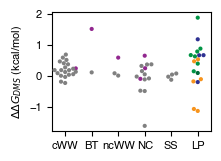

In [18]:
# rename 1.0: WW, 2.0: BT, 3: ncWW, 4: NC, 5: SS, 6: LP
ddG_merged['canonical'] = ddG_merged['canonical'].replace({
    1.0: 'cWW',
    2.0: 'BT',
    3.0: 'ncWW',
    4.0: 'NC',
    5.0: 'SS',
    6.0: 'LP'
})

# set lp_section values to colors: {'not': 'gray', 'MC': 009444, 'MCR': 006838, 'TLR':2e3192, 'TL': 1c75bc, 'P5c': f7941d, "J5/5a": 92278f
lp_section_colors = {
    'not': 'gray',
    'MC': '#009444',
    'MCR': '#006838',
    'TLR': '#2e3192',
    'TL': '#1c75bc',
    'P5c': '#f7941d',
    'J5/5a': '#92278f'
}

fig, ax = plt.subplots(figsize=(2.25, 1.65))
sns.swarmplot(data = ddG_merged, x='canonical', y='ddG', order=['cWW', 'BT', 'ncWW', 'NC', 'SS', 'LP'], 
              hue = 'lp_section', palette = lp_section_colors, size = 3, ax = ax)
# remove x label
ax.set_xlabel('')
# set y label
ax.set_ylabel(r'$\Delta\Delta G_{DMS}$ (kcal/mol)')

# no legend
ax.legend_.remove()

plt.tight_layout()
plt.savefig('p4p6_ddG_swarmplots.pdf')

In [32]:
ddG_merged

,nt_site,nt_base,log_kobs_nomg,log_kobs_err_nomg,dG_nomg,r2_nomg,log_kobs_mg,log_kobs_err_mg,dG_mg,r2_mg,canonical,lp_section,Unnamed: 4,ddG
0,104,A,-3.775280,0.039808,0.411026,0.981779,-3.795475,0.071300,0.428881,0.975766,ncWW,not,1: canonical,0.017855
1,105,A,-4.047125,0.045539,0.638676,0.976153,-4.165104,0.077981,0.730599,0.971924,ncWW,not,2: base-triple,0.091923
2,109,C,-4.365995,0.035195,0.707925,0.985545,-4.499681,0.083820,0.809164,0.966432,LP,MCR,3: WW_non-canonical,0.101239
3,113,A,-4.182189,0.028209,0.743639,0.990689,-4.636739,0.095737,1.071636,0.956610,NC,not,4: NC,0.327997
4,114,A,-3.406555,0.027499,0.043210,0.991309,-3.458740,0.033007,0.101494,0.994756,NC,not,5: SS,0.058285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,261,A,-5.490267,0.085721,1.630607,0.919276,-5.448170,0.086865,1.604038,0.963795,NaN,NaN,NaN,-0.026569
66,262,A,-4.551276,0.056110,1.012275,0.963976,-4.814791,0.059075,1.192756,0.982990,NaN,NaN,NaN,0.180482
67,263,C,-6.721343,0.215547,2.246925,0.642335,-6.297629,0.260076,1.988792,0.747605,NaN,NaN,NaN,-0.258134
68,265,A,-6.427110,0.171735,2.208222,0.738889,-6.461498,0.181311,2.229078,0.859019,NaN,NaN,NaN,0.020856


/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 19.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


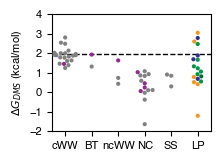

In [ ]:
df_merged_mg = df_merged_AC[df_merged_AC['buffer'] == 'dG_mg']
# filter to under nt_site 255
df_merged_mg = df_merged_mg[df_merged_mg['nt_site'] < 255]

# rename 1.0: WW, 2.0: BT, 3: ncWW, 4: NC, 5: SS, 6: LP
df_merged_mg['canonical'] = df_merged_mg['canonical'].replace({
    1.0: 'cWW',
    2.0: 'BT',
    3.0: 'ncWW',
    4.0: 'NC',
    5.0: 'SS',
    6.0: 'LP'
})

# set lp_section values to colors: {'not': 'gray', 'MC': 009444, 'MCR': 006838, 'TLR':2e3192, 'TL': 1c75bc, 'P5c': f7941d, "J5/5a": 92278f
lp_section_colors = {
    'not': 'gray',
    'MC': '#009444',
    'MCR': '#006838',
    'TLR': '#2e3192',
    'TL': '#1c75bc',
    'P5c': '#f7941d',
    'J5/5a': '#92278f'
}

# sns swarmplot dG_nomg vs dG_mg colored by canonical annotation
fig, ax = plt.subplots(figsize=(2.25, 1.65))
sns.swarmplot(data=df_merged_mg, x='canonical', y='dG', order=['cWW', 'BT', 'ncWW', 'NC', 'SS', 'LP'], 
              hue = 'lp_section', size = 3, ax = ax, palette=lp_section_colors)
# horizontal line at 1.95
ax.axhline(1.95, color='black', linestyle='--', linewidth=1)
# remove x label
ax.set_xlabel('')
# set y label
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')

# set y-axis -2 to 4
ax.set_ylim(-2, 4)

# show y tick every 1
ax.yaxis.set_ticks(np.arange(-2, 5, 1))

# no legend
ax.legend_.remove()

plt.tight_layout()
plt.savefig('p4p6_dG_swarmplots.pdf')